In [85]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [86]:
%load_ext autoreload
%autoreload 2

import re
import os
from pathlib import Path
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import sys
import importlib
from dotenv import load_dotenv

# 1. Detect Environment
try:
    from notebookutils import mssparkutils
    IS_FABRIC = True
    print("Running in Microsoft Fabric")
except ImportError:
    IS_FABRIC = False
    print("Running Locally")

# 2. Define Paths based on Environment
if IS_FABRIC:
    # Fabric: Use Lakehouse Paths (OneLake mounted path)
    BASE_DIR = Path("/lakehouse/default/Files")
    
    # Try to load .env from the Lakehouse Files root if it exists
    env_path = BASE_DIR / ".env"
    if env_path.exists():
        load_dotenv(dotenv_path=env_path)
        print(f"Loaded configuration from {env_path}")
    
    # Fabric Paths
    # Assuming docs and data are uploaded to Files/
    PROJECT_ROOT = BASE_DIR
    DATA_MODEL_FILE = BASE_DIR / "docs/AIMS Data Model.txt"
    PARQUET_DIR = BASE_DIR / os.getenv("BRONZE_PATH", "data/Samples_LH_Bronze_Aims_26_parquet")
    
else:
    # Local: Use .env or defaults
    load_dotenv()
    
    # Prioritize local development path in sys.path
    project_root_local = Path.cwd().parent.resolve()
    if str(project_root_local) not in sys.path:
        sys.path.insert(0, str(project_root_local))
        
    PROJECT_ROOT = Path("..")
    DATA_MODEL_FILE = PROJECT_ROOT / "docs/AIMS Data Model.txt"
    PARQUET_DIR = PROJECT_ROOT / "data/Samples_LH_Bronze_Aims_26_parquet"

print(f"Configuration:\n Environment: {'Fabric' if IS_FABRIC else 'Local'}")
print(f" Project Root: {PROJECT_ROOT}")
print(f" Data Model: {DATA_MODEL_FILE}")
print(f" Parquet Dir: {PARQUET_DIR}")

import aims_data_platform
# Force reload to pick up changes if it was already loaded from site-packages
importlib.reload(aims_data_platform)
print(f"aims_data_platform location: {aims_data_platform.__file__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Locally
Configuration:
 Environment: Local
 Project Root: ..
 Data Model: ../docs/AIMS Data Model.txt
 Parquet Dir: ../data/Samples_LH_Bronze_Aims_26_parquet
aims_data_platform location: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/aims_data_platform/__init__.py


In [87]:
from aims_data_platform.schema_reconciliation import (
    parse_data_model, 
    get_parquet_metadata, 
    format_size, 
    analyze_comparison, 
    analyze_extra_files,
    generate_model,
    check_relationship
)

In [88]:
# Run the Analysis
print("Parsing Data Model...")
tables = parse_data_model(DATA_MODEL_FILE)
print(f"Found {len(tables)} tables in model definition.")

print("Analyzing Parquet Files...")
# Execute comparison analysis; returns a tuple of (DataFrame, set_of_modeled_files)
df_results, modeled_files = analyze_comparison(tables, PARQUET_DIR)

# Calculate Summary Metrics
total_tables = len(df_results)
missing_files = len(df_results[df_results['Status'] == 'MISSING FILE'])
matches = len(df_results[df_results['Status'].str.contains('MATCH')])
mismatches = len(df_results[df_results['Status'] == 'MISMATCH'])

print(f"\nSummary (Model vs Files):")
print(f"Total Tables Defined in Model: {total_tables}")
print(f"✅ Fully Matched:              {matches}")
print(f"⚠️ Schema Mismatches:          {mismatches}")
print(f"❌ Missing Files:              {missing_files}")

# --- NEW: Analyze Extra Files ---
df_extra = analyze_extra_files(modeled_files, PARQUET_DIR)
extra_files_count = len(df_extra)

print(f"\nExtra Files Analysis:")
print(f"Total Parquet Files Found:     {len(list(PARQUET_DIR.glob('*.parquet')))}")
print(f"Files accounted for in Model:  {len(modeled_files)}")
print(f"❓ Unmodeled Files (Extra):    {extra_files_count}")

Parsing Data Model...
Found 29 tables in model definition.
Analyzing Parquet Files...

Summary (Model vs Files):
Total Tables Defined in Model: 29
✅ Fully Matched:              23
⚠️ Schema Mismatches:          21
❌ Missing Files:              4

Extra Files Analysis:
Total Parquet Files Found:     68
Files accounted for in Model:  29
❓ Unmodeled Files (Extra):    43

Summary (Model vs Files):
Total Tables Defined in Model: 29
✅ Fully Matched:              23
⚠️ Schema Mismatches:          21
❌ Missing Files:              4

Extra Files Analysis:
Total Parquet Files Found:     68
Files accounted for in Model:  29
❓ Unmodeled Files (Extra):    43


## Detailed Reconciliation Report

The following table presents the reconciliation status for each table entity.
*   **Missing_Cols**: Attributes defined in the logical data model but absent in the physical Parquet files.
*   **Extra_Cols**: Attributes present in the physical Parquet files but not defined in the logical data model.

In [89]:
# Render the DataFrame with conditional formatting
def color_status(val):
    color = 'black'
    if val == 'MATCH':
        color = 'green'
    elif 'MATCH' in val:
        color = 'darkgreen'
    elif val == 'MISMATCH':
        color = 'orange'
    elif val == 'MISSING FILE':
        color = 'red'
    return f'color: {color}; font-weight: bold'

# Format lists as strings for display
df_display = df_results.copy()
df_display['Missing_Cols'] = df_display['Missing_Cols'].apply(lambda x: ', '.join(x[:5]) + ('...' if len(x) > 5 else '') if x else '-')
df_display['Extra_Cols'] = df_display['Extra_Cols'].apply(lambda x: ', '.join(x[:5]) + ('...' if len(x) > 5 else '') if x else '-')

# Apply styling
df_display.style.map(color_status, subset=['Status'])

,Table,Status,Rows,Size,Model_Col_Count,Parquet_Col_Count,Missing_Cols,Extra_Cols,Details
0,Routes,MISMATCH,33,5.99 KB,16,13,"COPIEDFROM, KINO_CSID, KINO_CUID, KINO_CWHEN, KINO_USID...","CREATEDBY, WHENCREATED, UPDATEDBY, LASTUPDATED",Missing 7 columns
1,Phases,MISMATCH,6,2.46 KB,11,8,"LATESTVOLUMERECORD, KINO_CSID, KINO_CUID, KINO_CWHEN, KINO_USID...","CREATEDBY, WHENCREATED, UPDATEDBY, LASTUPDATED",Missing 7 columns
2,Stages,MISMATCH,8,2.53 KB,11,8,"EIRTYPE, KINO_CSID, KINO_CUID, KINO_CWHEN, KINO_USID...","CREATEDBY, WHENCREATED, UPDATEDBY, LASTUPDATED",Missing 7 columns
3,Owners,AUDIT MISSING,28,3.52 KB,11,9,"KINO_CSID, KINO_CUID, KINO_CWHEN, KINO_USID, KINO_UUID...","CREATEDBY, WHENCREATED, UPDATEDBY, LASTUPDATED",Missing 6 Audit Cols (KINO)
4,RelationshipTypes,MISMATCH,39,10.97 KB,24,17,"DISPLAYASTABLE, DISPLAYREVERSEASTABLE, DISPLAYORDER, DISPLAYCOLOUR, DEFAULTVIEW...","OWNERID, CREATEDBY, WHENCREATED, UPDATEDBY, LASTUPDATED",Missing 12 columns
5,LinkTypes,MISMATCH,52,6.59 KB,17,13,"DISPLAYORDER, DISPLAYASPRIMARYASSETIMAGE, KINO_CSID, KINO_CUID, KINO_CWHEN...","CREATEDBY, WHENCREATED, UPDATEDBY, LASTUPDATED",Missing 8 columns
6,Organisations,MISMATCH,28,3.60 KB,31,9,"KINO_CSID, KINO_CUID, KINO_CWHEN, KINO_USID, KINO_UUID...","PARENTID, OWNERID",Missing 24 columns
7,People,MISMATCH,1898,108.85 KB,64,14,"PREDECESSOR, SUCCEEDEDON, CREATEUSERPROCESS, INITIALPASSWORD, USERIDFORNEWACCOUNT...","ORGANISATIONID, CREATEDBY, WHENPERSONCREATED",Missing 53 columns
8,Users,MISSING FILE,0,0 B,3,0,-,-,File aims_users.parquet not found
9,AssetClasses,MISMATCH,5644,624.78 KB,57,40,"LatestLog, GROUPINGCLASSFORHIERARCHYREPOR, OLDHIERARCHYENTITY, DISPLAYCOLOUR, CONTAINER...","PARENTID, CREATEDBY, WHENCREATED, UPDATEDBY, LASTUPDATED...",Missing 33 columns


## Analysis of Missing Columns

Preliminary analysis suggests that a significant number of schema mismatches are attributable to missing **System Audit Columns** (KINO columns). The following section performs a verification of this hypothesis.

In [90]:
# Filter for Mismatches
mismatches_df = df_results[df_results['Status'] == 'MISMATCH'].copy()

def analyze_missing_types(missing_list):
    kino_count = sum(1 for col in missing_list if 'KINO' in col.upper())
    other_count = len(missing_list) - kino_count
    return kino_count, other_count

mismatches_df['KINO_Missing'], mismatches_df['Other_Missing'] = zip(*mismatches_df['Missing_Cols'].apply(analyze_missing_types))

# Identify tables missing non-KINO columns (Potential Data Integrity Issues)
real_issues = mismatches_df[mismatches_df['Other_Missing'] > 0][['Table', 'Other_Missing', 'Missing_Cols']]

print(f"Tables with missing KINO columns only: {len(mismatches_df) - len(real_issues)}")
print(f"Tables with potentially real missing data: {len(real_issues)}")

if not real_issues.empty:
    print("\nTables with non-system missing columns:")
    display(real_issues)
else:
    print("\nVerification Complete: All missing columns are identified as KINO system audit columns.")

Tables with missing KINO columns only: 0
Tables with potentially real missing data: 21

Tables with non-system missing columns:


,Table,Other_Missing,Missing_Cols
0,Routes,1,"[COPIEDFROM, KINO_CSID, KINO_CUID, KINO_CWHEN,..."
1,Phases,1,"[LATESTVOLUMERECORD, KINO_CSID, KINO_CUID, KIN..."
2,Stages,1,"[EIRTYPE, KINO_CSID, KINO_CUID, KINO_CWHEN, KI..."
4,RelationshipTypes,6,"[DISPLAYASTABLE, DISPLAYREVERSEASTABLE, DISPLA..."
5,LinkTypes,2,"[DISPLAYORDER, DISPLAYASPRIMARYASSETIMAGE, KIN..."
6,Organisations,18,"[KINO_CSID, KINO_CUID, KINO_CWHEN, KINO_USID, ..."
7,People,47,"[PREDECESSOR, SUCCEEDEDON, CREATEUSERPROCESS, ..."
9,AssetClasses,27,"[LatestLog, GROUPINGCLASSFORHIERARCHYREPOR, OL..."
10,AttributeGroups,7,"[DISPLAYORDER, DEFAULTVIEW, DEFINESMATRIX, ROW..."
11,Attributes,17,"[ATTRIBUTELEVEL, GRAPHCOLOUR, LINEARATTRIBUTE,..."


In [91]:
# Display Extra Files
if extra_files:
    df_extra = pd.DataFrame(extra_files, columns=["Unmodeled File Name"])
    # Attempt to infer table name from filename
    df_extra["Guessed Table Name"] = df_extra["Unmodeled File Name"].apply(lambda x: x.replace("aims_", "").replace(".parquet", "").title())
    display(df_extra)
else:
    print("No extra files found.")

,Unmodeled File Name,Guessed Table Name
0,aims_activitydates.parquet,Activitydates
1,aims_assetconsents.parquet,Assetconsents
2,aims_consentlinks.parquet,Consentlinks
3,aims_consentmilestones.parquet,Consentmilestones
4,aims_consentmilestonetypes.parquet,Consentmilestonetypes
5,aims_consents.parquet,Consents
6,aims_consenttypemilestones.parquet,Consenttypemilestones
7,aims_consenttypes.parquet,Consenttypes
8,aims_informationneedassetclass.parquet,Informationneedassetclass
9,aims_informationneedattributes.parquet,Informationneedattributes


## 2.1 Data Volume Insights
Understanding the distribution of data across tables helps identify the largest entities and potential data skew.

2025-12-07 20:08:50,703 - py.warnings - WARNING - /tmp/ipykernel_3957901/3890796446.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_viz, x='Rows', y='Table', palette='viridis')



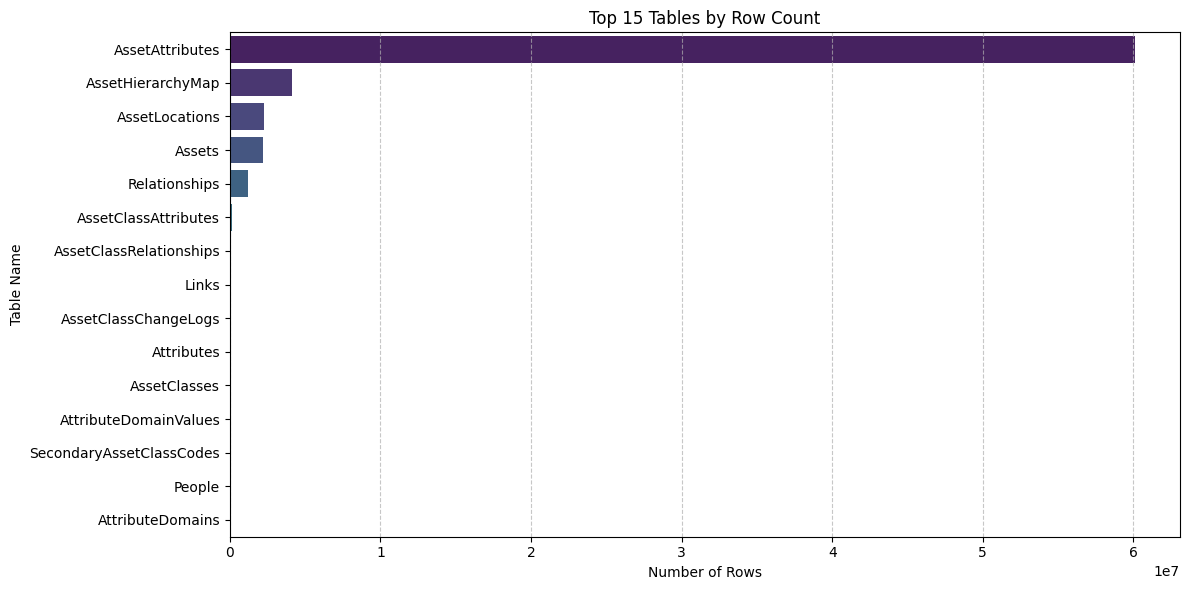

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
df_viz = df_results.copy()
df_viz['Rows'] = pd.to_numeric(df_viz['Rows'], errors='coerce').fillna(0)
df_viz = df_viz.sort_values('Rows', ascending=False).head(15)

# Plot Top 15 Tables by Row Count
plt.figure(figsize=(12, 6))
sns.barplot(data=df_viz, x='Rows', y='Table', palette='viridis')
plt.title('Top 15 Tables by Row Count')
plt.xlabel('Number of Rows')
plt.ylabel('Table Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2.2 Schema Health Analysis
This section quantifies the "health" of the schema by calculating the percentage of expected columns that are actually present in the files. A lower percentage indicates significant drift from the defined model.

2025-12-07 20:08:51,015 - py.warnings - WARNING - /tmp/ipykernel_3957901/379207810.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_issues.head(10), x='Match_Pct', y='Table', palette='RdYlGn')



Tables with lowest schema conformity:


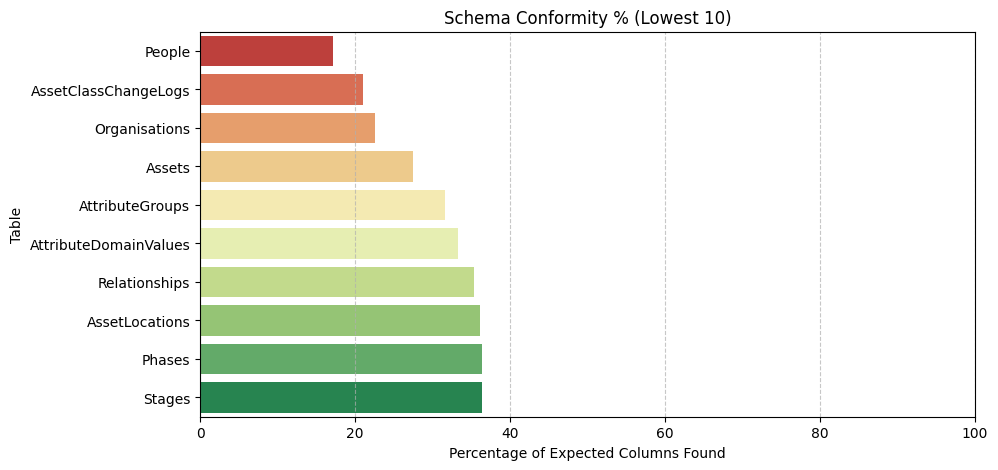

In [93]:
# Calculate Schema Match Percentage
def calculate_match_pct(row):
    if row['Status'] == 'MISSING FILE':
        return 0.0
    
    # Get expected columns count from the parsed tables
    table_name = row['Table']
    if table_name in tables:
        total_expected = len(tables[table_name])
        missing_count = len(row['Missing_Cols']) if isinstance(row['Missing_Cols'], list) else 0
        
        if total_expected == 0: return 100.0
        return ((total_expected - missing_count) / total_expected) * 100
    return 0.0

df_health = df_results.copy()
df_health['Match_Pct'] = df_health.apply(calculate_match_pct, axis=1)

# Filter for tables that exist but have issues
df_issues = df_health[(df_health['Match_Pct'] < 100) & (df_health['Status'] != 'MISSING FILE')].sort_values('Match_Pct')

if not df_issues.empty:
    print("Tables with lowest schema conformity:")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_issues.head(10), x='Match_Pct', y='Table', palette='RdYlGn')
    plt.title('Schema Conformity % (Lowest 10)')
    plt.xlabel('Percentage of Expected Columns Found')
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("All existing files perfectly match their schema definitions!")

## Unmodeled Files (Extra Data)

The files listed below exist within the data directory but are **not defined** in the `AIMS Data Model.txt`. This indicates that the current data model documentation may be a subset of the complete system, or that these files represent auxiliary or temporary tables.

## 3. Generate Corrected Data Model
Given the discrepancies between the documentation and the actual data, a "Source of Truth" model is reverse-engineered from the Parquet files.
The following script generates a revised model file, `docs/AIMS_Data_Model_Actual.txt`, which:
1. Incorporates all files identified in the data directory.
2. Removes attributes that are not present in the physical data.
3. Appends new attributes discovered in the data.
4. Preserves original data types (e.g., `varchar(36)`) where feasible, while inferring types for newly discovered attributes.

In [94]:
output_file = PROJECT_ROOT / "docs/AIMS_Data_Model_Actual.txt"

# Generate the model (includes table generation, relationship inference, and validation)
generate_model(tables, PARQUET_DIR, output_file=output_file)

# Preview the generated file
print("\n--- Preview Generated Model ---")
with open(output_file, 'r') as f:
    lines = f.readlines()
    print(''.join(lines[:20]))
    print("...")
    
    # Print some relationships
    print("\n--- Preview Relationships ---")
    count = 0
    for line in lines:
        if line.startswith("Ref:"):
            print(line.strip())
            count += 1
            if count >= 10: 
                print("... (more relationships)")
                break

Generating new data model...
Inferring and validating relationships...
  Checking AssetAttributes.ASSETID -> Assets.ID... Inferring and validating relationships...
  Checking AssetAttributes.ASSETID -> Assets.ID... (Sampling 100000) (Sampling 100000) VALID 100.00% (12131/12131) (Sampled 100000)
  Checking AssetAttributes.ATTRIBUTEID -> Attributes.ID... VALID 100.00% (12131/12131) (Sampled 100000)
  Checking AssetAttributes.ATTRIBUTEID -> Attributes.ID... (Sampling 100000) VALID 100.00% (21/21) (Sampled 100000)
  Checking AssetAttributes.ASSETLOCATIONID -> AssetLocations.ID... (Sampling 100000) VALID 100.00% (21/21) (Sampled 100000)
  Checking AssetAttributes.ASSETLOCATIONID -> AssetLocations.ID... (Sampling 100000) (Sampling 100000) INVALID 0.00% (0/9353) (Sampled 100000)
  Checking AssetAttributes.OWNERID -> Owners.ID... INVALID 0.00% (0/9353) (Sampled 100000)
  Checking AssetAttributes.OWNERID -> Owners.ID... (Sampling 100000) INVALID 0.00% (0/3) (Sampled 100000)
  Checking AssetAttr

In [ ]:
# Helper functions: export plot to PNG and build MIME payload
import base64
from pathlib import Path as _Path
import matplotlib.pyplot as _plt
from typing import Union

def save_plot_png(fig_or_ax: Union[_plt.Figure, _plt.Axes], path: Union[str, _Path]):
    """Save a matplotlib Figure or Axes to a PNG file at `path`."""
    out_path = _Path(path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if isinstance(fig_or_ax, _plt.Figure):
        fig = fig_or_ax
    elif isinstance(fig_or_ax, _plt.Axes):
        fig = fig_or_ax.figure
    else:
        raise TypeError("Expected matplotlib Figure or Axes")
    fig.savefig(out_path, format="png", dpi=150, bbox_inches="tight")
    return out_path

def build_image_payload(path: Union[str, _Path], mime: str = "image/png"):
    """Build a dict payload containing base64-encoded image data with proper mimeType."""
    file_path = _Path(path)
    with open(file_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return {
        "mimeType": mime,
        "data": b64,
        "filename": file_path.name
    }
